Load embeddings.

In [1]:
import torch

embeddings = torch.load('../data/embeddings.pt', map_location=torch.device('cpu'))
embeddings = embeddings.squeeze().numpy()

print('Shape of embeddings:', embeddings.shape)

Shape of embeddings: (48669, 256)


Load dataloader for event metadata.

In [2]:
import numpy as np
import pandas as pd

dataloader = torch.load('../data/dataloader.pth')
event_ids = np.array([f.split('_')[0] for f in dataloader.dataset.files])
df_event = pd.read_csv('../data/events.csv')
event_types = np.array([
    df_event.loc[df_event['eventID'] == int(i), 'event_type'].item()
    for i in event_ids
])

There are two types of event: earthquare, nuclear explosion.

Let's predict the event type from its signal embeddings.

In [3]:
print('Number of signals by event type:')
print('- earthquake:', len(event_ids[event_types == 'earthquake']))
print('- nuclear explosion:', len(event_ids[event_types == 'nuclear explosion']))

Number of signals by event type:
- earthquake: 48638
- nuclear explosion: 31


The data is highly imbalanced

Split events for training and test.

In [4]:
from sklearn.model_selection import train_test_split

train_events, test_events = train_test_split(df_event['eventID'].values,
                                             stratify=df_event['event_type'])

is_train = np.isin(event_ids, train_events)
is_test = np.isin(event_ids, test_events)

Train a logistic regression.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X_train = embeddings[is_train]
X_test = embeddings[is_test]
y_train = event_types[is_train]
y_test = event_types[is_test]

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
print('Accuracy:')
print('- training', lr.score(X_train, y_train))
print('- test', lr.score(X_test, y_test))
print('')
print('Test confusion matrix:')
y_pred = lr.predict(X_test)
print(confusion_matrix(y_test, y_pred))

Accuracy:
- training 0.7019022122023391
- test 0.7044902912621359

Test confusion matrix:
[[9284 3891]
 [   5    4]]


Visualize the logistic regression coefficients.

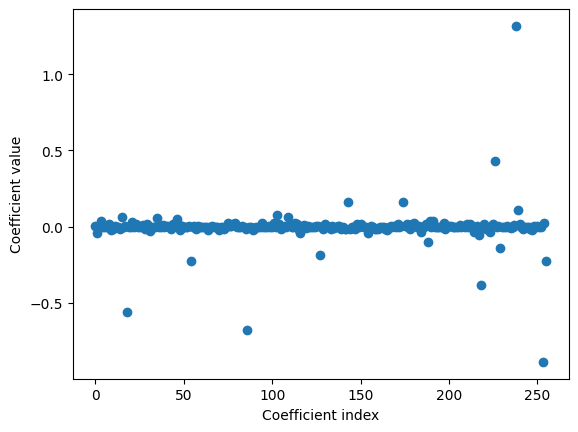

In [6]:
import matplotlib.pyplot as plt

plt.scatter(range(len(lr.coef_.flatten())), lr.coef_)
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')
plt.show()

Only one coefficient is >1 in absolute value.

Let's predict the event type using the corresponding embedding dimension only.

In [7]:
best_coef = np.argmax(np.abs(lr.coef_))

In [8]:
embeddings_1d = embeddings[:,best_coef]
X_train = embeddings_1d[is_train].reshape(-1, 1)
X_test = embeddings_1d[is_test].reshape(-1, 1)
y_train = event_types[is_train]
y_test = event_types[is_test]

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
print('Accuracy:')
print('- training', lr.score(X_train, y_train))
print('- test', lr.score(X_test, y_test))
print('')
print('Test confusion matrix:')
y_pred = lr.predict(X_test)
print(confusion_matrix(y_test, y_pred))


Accuracy:
- training 0.7012822319289841
- test 0.703807645631068

Test confusion matrix:
[[9275 3900]
 [   5    4]]
